In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
from glob import glob
from matplotlib import pyplot as plt
import pickle
import math

# BASEMODEL_CONFIG = {
#     "vocab_size": 50257,
#     "max_length": 300,
#     "context_length": 300,
#     "embedding_dim": 768,
#     "n_layers": 12,
#     "n_heads": 16,
#     "dropout": 0.15,
#     "qkv_bias": False,
#     "batch_size": 2,
#     "learning_rate": 0.0004,
#     "weight_decay": 0.1
# }

BASEMODEL_CONFIG = {
    "vocab_size": 50257,
    "max_length": 300,
    "context_length": 300,
    "embedding_dim": 384,
    "n_layers": 8,
    "n_heads": 8,
    "dropout": 0.10,
    "qkv_bias": False,
    "batch_size": 8,
    "learning_rate": 0.0004,
    "weight_decay": 0.1
}

use_10k_base = True
SEED = 19
print(f"Is CUDA available: {torch.cuda.is_available()}")

Is CUDA available: True


## Data load and preparation

In [2]:
class TextTokenizer:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def encode(self, text):
        return self.tokenizer.encode(text, allowed_special={'<|endoftext|>'})

    def to_token_ids(self, text):
        encoded_text = self.encode(text)
        encoded_tensor = torch.tensor(encoded_text).unsqueeze(0)

        return encoded_tensor

    def to_text(self, token_ids):
        flat = token_ids.squeeze(0)
        decoded_text = self.tokenizer.decode(flat.tolist())

        return decoded_text


class ModelDataset(Dataset):
    def __init__(self, txt, tt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tt.encode(txt)
        self.vocab_size = len(token_ids)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader(txt, tt: TextTokenizer, batch_size=16, max_length=512, stride=256, shuffle=True, drop_last=True, num_workers=0):
    model_dataset = ModelDataset(txt, tt, max_length=max_length, stride=stride)
    dataloader = DataLoader(model_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [3]:
tt = TextTokenizer(tokenizer=tiktoken.get_encoding("gpt2"))

raw_txt = ""

if use_10k_base:
    train_test_ratio = 0.95
    filepaths = glob("dataset/gutenberg_1k/*.pkl")
    for filepath in filepaths:
        with open(filepath, "rb") as f:
            file = pickle.load(f)
            raw_txt += file + '<|endoftext|>'

else:
    train_test_ratio = 0.9
    filepaths = glob("dataset/Pretraining/*.txt")
    for txt_filepath in filepaths:
        with open(txt_filepath, "r", encoding="utf-8") as f:
            raw_txt += f.read() + '<|endoftext|>'


split_index = int(train_test_ratio * len(raw_txt))

train_data = raw_txt[:split_index]
test_data = raw_txt[split_index:]

print(f"Train data size: {len(train_data)}")
print(f"Test data size:  {len(test_data)}")

train_loader = create_dataloader(
    train_data,
    tt,
    batch_size=BASEMODEL_CONFIG["batch_size"],
    max_length=BASEMODEL_CONFIG["context_length"],
    stride=BASEMODEL_CONFIG["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

test_loader = create_dataloader(
    test_data,
    tt,
    batch_size=BASEMODEL_CONFIG["batch_size"],
    max_length=BASEMODEL_CONFIG["context_length"],
    stride=BASEMODEL_CONFIG["context_length"],
    shuffle=False,
    drop_last=False,
    num_workers=0
)

print(f"{len(train_loader)} training batches")
print(f"{len(test_loader)} test batches")

Train data size: 341701751
Test data size:  17984303
39462 training batches
2065 test batches


## Attention mechanism

In [4]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, num_head, context_length, dropout, qkv_bias=False):
        super().__init__()
        assert (d_out % num_head == 0), "d_out must be divisible by num_head"

        self.d_out = d_out
        self.num_head = num_head
        self.head_dim = d_out // num_head
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        batch, num_tokens, d_in = x.shape
        keys = self.W_query(x)
        queries = self.W_key(x)
        values = self.W_value(x)

        keys = keys.view(batch, num_tokens, self.num_head, self.head_dim).transpose(1, 2)
        values = values.view(batch, num_tokens, self.num_head, self.head_dim).transpose(1, 2)
        queries = queries.view(batch, num_tokens, self.num_head, self.head_dim).transpose(1, 2)

        attention_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores = attention_scores.masked_fill(mask_bool, -torch.inf)

        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)

        context_vector = (attention_weights @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(batch, num_tokens, self.d_out)
        context_vector = self.out_proj(context_vector)

        return context_vector

## Model architecture

In [5]:
class BaseModel(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings  = torch.nn.Embedding(config["vocab_size"], config["embedding_dim"])
        self.pos_embeddings    = torch.nn.Embedding(config["context_length"], config["embedding_dim"])
        self.dropout_embedding = torch.nn.Dropout(config["dropout"])

        self.transformer_blocks = torch.nn.Sequential(*[TransformerBlock(config) for _ in range(config["n_layers"])])
        self.final_norm = NormLayer(config["embedding_dim"])
        self.out_head = torch.nn.Linear(config["embedding_dim"], config["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape

        token_embeddings = self.token_embeddings(in_idx)
        pos_embeddings = self.pos_embeddings(torch.arange(seq_length, device=in_idx.device))

        x = token_embeddings + pos_embeddings
        x = self.dropout_embedding(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits


class TransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=config["embedding_dim"],
            d_out=config["embedding_dim"],
            num_head=config["n_heads"],
            context_length=config["context_length"],
            dropout=config["dropout"],
            qkv_bias=config["qkv_bias"]
        )

        self.ff = FeedForward(config)
        self.norm1 = NormLayer(config["embedding_dim"])
        self.norm2 = NormLayer(config["embedding_dim"])
        self.drop_shortcut = torch.nn.Dropout(config["dropout"])

    def forward(self, x):
        shortcut = x

        x = self.norm1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class NormLayer(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = torch.nn.Parameter(torch.ones(normalized_shape, dtype=torch.float))
        self.shift = torch.nn.Parameter(torch.zeros(normalized_shape, dtype=torch.float))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) * torch.rsqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0) / torch.pi) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(config["embedding_dim"], 4 * config["embedding_dim"]),
            GELU(),
            torch.nn.Linear(4 * config["embedding_dim"], config["embedding_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


In [6]:
model = BaseModel(BASEMODEL_CONFIG)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total number of parameters: 52,899,840
Total size of the model: 201.80 MB


## Generating words

In [7]:
def generate_text(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

## Model training

In [8]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss / num_batches


def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, eval_freq, eval_iter, start_context, tt: TextTokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step, epoch_step = 0, -1, -1

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            epoch_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1}/{num_epochs} "
                    f"(Step {int(epoch_step/eval_freq)}/{int(math.ceil(len(train_loader)/eval_freq))} [{(epoch_step/len(train_loader) * 100):.2f}%]): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(model, tt, device, start_context)
        epoch_step = -1

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)

    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tt: TextTokenizer, device, start_context):
    model.eval()
    context_size = model.pos_embeddings.weight.shape[0]
    encoded = tt.to_token_ids(start_context).to(device)

    with torch.no_grad():
        token_ids = generate_text(
            model,
            encoded,
            max_new_tokens=50,
            context_size=context_size,
            temperature=1.75,
            top_k=25,
        )

    decoded = tt.to_text(token_ids)
    print(decoded.replace("\n", " "))
    model.train()

In [9]:
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=BASEMODEL_CONFIG["learning_rate"],
    weight_decay=BASEMODEL_CONFIG["weight_decay"],
)
num_epochs = 1

train_losses, val_losses, track_tokens_seen = train_model(
    model,
    train_loader,
    test_loader,
    optimizer,
    num_epochs,
    device,
    eval_freq=50,
    eval_iter=5,
    start_context="Hello, I",
    tt=tt
)

Ep 1/1 (Step 0/789 [0.00%]): Train loss 10.127, Val loss 10.115
Ep 1/1 (Step 1/789 [0.13%]): Train loss 6.501, Val loss 6.545
Ep 1/1 (Step 2/789 [0.25%]): Train loss 5.976, Val loss 6.303
Ep 1/1 (Step 3/789 [0.38%]): Train loss 6.007, Val loss 6.067
Ep 1/1 (Step 4/789 [0.51%]): Train loss 5.620, Val loss 5.923
Ep 1/1 (Step 5/789 [0.63%]): Train loss 5.933, Val loss 5.838
Ep 1/1 (Step 6/789 [0.76%]): Train loss 5.667, Val loss 5.733
Ep 1/1 (Step 7/789 [0.89%]): Train loss 5.462, Val loss 5.715
Ep 1/1 (Step 8/789 [1.01%]): Train loss 5.564, Val loss 5.625
Ep 1/1 (Step 9/789 [1.14%]): Train loss 5.464, Val loss 5.555
Ep 1/1 (Step 10/789 [1.27%]): Train loss 5.271, Val loss 5.430
Ep 1/1 (Step 11/789 [1.39%]): Train loss 5.549, Val loss 5.340
Ep 1/1 (Step 12/789 [1.52%]): Train loss 5.265, Val loss 5.295
Ep 1/1 (Step 13/789 [1.65%]): Train loss 5.405, Val loss 5.161
Ep 1/1 (Step 14/789 [1.77%]): Train loss 5.256, Val loss 5.166
Ep 1/1 (Step 15/789 [1.90%]): Train loss 5.217, Val loss 5.077


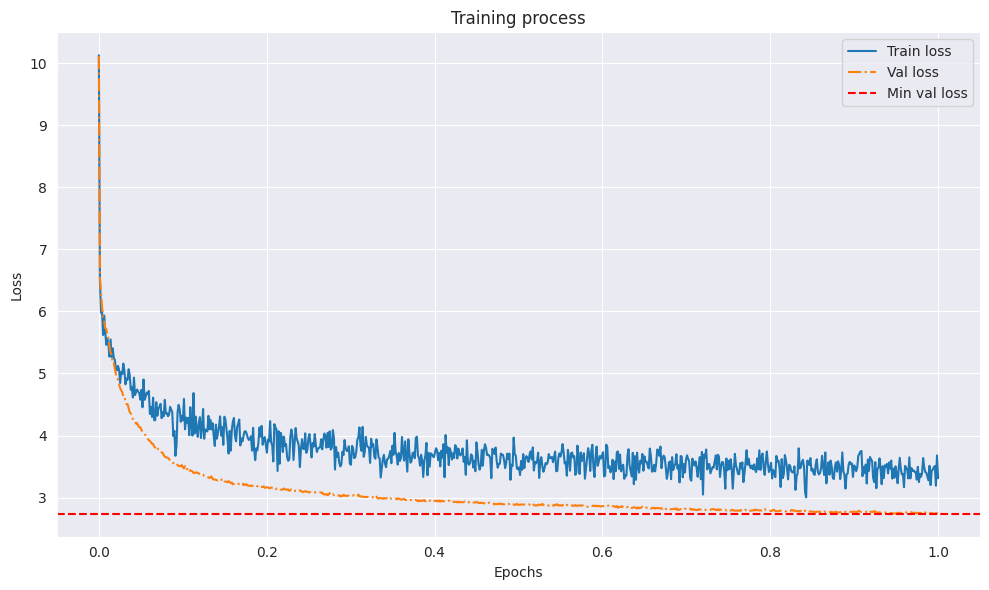

In [25]:
def plot_losses(epochs, train_losses, val_losses: list):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epochs, train_losses, label="Train loss")
    ax.plot(epochs, val_losses, label="Val loss", linestyle="-.")
    ax.set_title("Training process")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    min_val_loss = min(val_losses)
    min_index = epochs[val_losses.index(min_val_loss)]
    ax.axline((0, min_val_loss), (max(epochs), min_val_loss), linestyle="--", color="red", label="Min val loss")
    ax.axline((min_index, min(train_losses)), (min_index, max(val_losses)), linestyle="--", color="green", label="Best val loss epoch")

    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
epochs_tensor = epochs_tensor.cpu()
plot_train_losses_data = [item.cpu() for item in train_losses]
plot_val_losses_data = [item.cpu() for item in val_losses]
plot_losses(epochs_tensor, plot_train_losses_data, plot_val_losses_data)

## Model save and load

In [11]:
def save_model(model, optimizer=None, filename="model"):
    # filename with no extension
    if optimizer is None:
        torch.save(model.state_dict(), f"models/{filename}_MODEL.pth")
    else:
        torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"models/{filename}_MODEL-OPTIMIZER.pth"
        )


def load_model(filepath, config, device, with_optimizer=False):
    checkpoint = torch.load(filepath, map_location=device)
    model = BaseModel(config)

    if not with_optimizer:
        model.load_state_dict(checkpoint)
        model.train()
        return model

    model.load_state_dict(checkpoint["model_state_dict"])
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer

In [12]:
save_model(model, optimizer, filename="SmallerModel_1kBase")
save_model(model, None, filename="SmallerModel_1kBase")

In [29]:
model.to("cuda")
model.eval()

token_ids = generate_text(
    model=model,
    idx=tt.to_token_ids("I am").to("cuda"),
    max_new_tokens=100,
    context_size=BASEMODEL_CONFIG["context_length"],
    top_k=25,
    temperature=1.45,
)
print("Output text:\n", tt.to_text(token_ids))

Output text:
 I am ashamed, because we have the secret which had made us to
give the old people an hour of age. We shall not believe that we cannot see
a new man again,--but our friends will have gone far and a month,
and we shall be able to put a dead man down at our own home. When we were
thinking what to call him would become old we came together; and as soon as
we were going, I came to him for
